In [1]:

import time
from functools import partial
from typing import Callable

import jax.numpy as jnp
import typer
import jax
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.chains import run_sampling_nuts, run_warmup_nuts
from bpd.draw import draw_gaussian
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import logtarget_images
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_target_galaxy_params_simple,
)

import matplotlib.pyplot as plt 

In [6]:
slen = 63 
fft_size = 256
sigma_e_int = 0.35
background = 1.0

In [7]:
draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_logprior = partial(
    interim_gprops_logprior, sigma_e=sigma_e_int, free_flux_hlr=True, free_dxdy=True
)
_loglikelihood = partial(
    gaussian_image_loglikelihood,
    draw_fnc=draw_fnc,
    background=background,
    free_flux_hlr=True,
    free_dxdy=True,
)
_logtarget = partial(
    logtarget_images, logprior_fnc=_logprior, loglikelihood_fnc=_loglikelihood
)


In [8]:
def _run_warmup(key, init_pos, data, fixed_params):
    return run_warmup_nuts(
        key,
        init_pos,
        data,
        logtarget=partial(_logtarget, fixed_params=fixed_params),
        initial_step_size=0.1,
        max_num_doublings=5,
        n_warmup_steps=500,
    )


In [281]:
k = random.key(48) 
k1, k2 = random.split(k)

In [300]:
n_gals = 1 

# 2.4 = 10 SNR
galaxy_params = {'lf': 2.5, 'lhlr':0.05, 'e1': 0.1, 'e2':0.1, 'x': 0.25, 'y': 0.25, 'g1': 0.02, 'g2':0.0}
_galaxy_params = {k:jnp.array(v).reshape(1,) for k,v in galaxy_params.items()}
assert _galaxy_params["x"].shape == (n_gals,)

# get images
draw_params = {**_galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params["hlr"] = 10 ** draw_params.pop("lhlr")
target_image = get_target_images(
    k1, draw_params, background=background, slen=slen
)[0]
assert target_image.shape == (slen, slen)

In [301]:
true_params = get_true_params_from_galaxy_params(galaxy_params)
fixed_params = {'x': true_params.pop('x'), 'y': true_params.pop('y')}
true_params['dx'] = 0.0
true_params['dy'] = 0.0

init_position = {**true_params}

In [302]:
true_params, init_position

({'lf': 2.5,
  'lhlr': 0.05,
  'e1': Array(0.1199592, dtype=float64),
  'e2': Array(0.09956096, dtype=float64),
  'dx': 0.0,
  'dy': 0.0},
 {'lf': 2.5,
  'lhlr': 0.05,
  'e1': Array(0.1199592, dtype=float64),
  'e2': Array(0.09956096, dtype=float64),
  'dx': 0.0,
  'dy': 0.0})

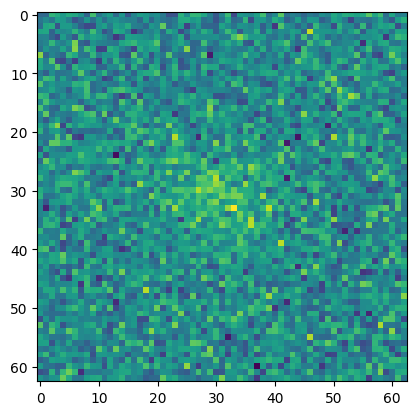

In [303]:
plt.imshow(target_image)

In [304]:
from bpd.utils import get_snr
from bpd.draw import draw_gaussian_galsim
nn = draw_gaussian_galsim(**{k:v.item() for k,v in draw_params.items()}, slen=63)
get_snr(nn, 1.0) # 2.4 = 10 SNR

Array(11.24062, dtype=float32)

In [305]:
run_warmup = jit(_run_warmup)

In [306]:
init_states, tuned_params, adapt_info = run_warmup(k2, init_position, target_image, fixed_params)

In [307]:
tuned_params

{'inverse_mass_matrix': Array([0.11780324, 0.10760313, 0.00553234, 0.00603735, 0.00149682,
        0.00148109], dtype=float64),
 'max_num_doublings': Array(5, dtype=int64, weak_type=True),
 'step_size': Array(0.52222814, dtype=float64, weak_type=True)}

In [308]:
states = adapt_info.state.position

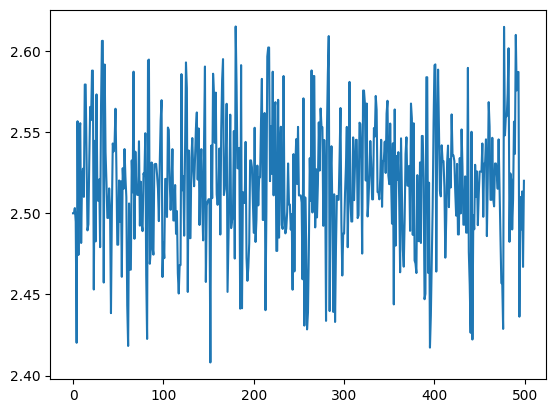

In [309]:
plt.plot(states['lf'])

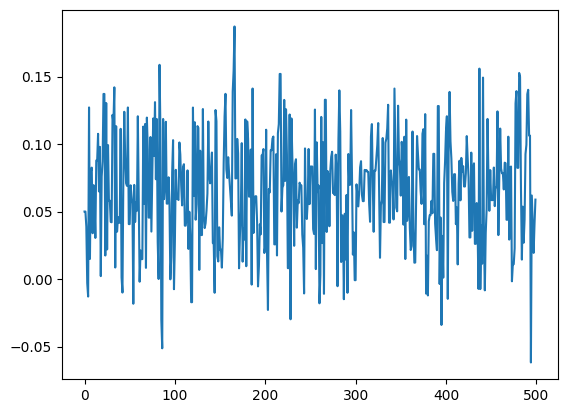

In [310]:
plt.plot(states['lhlr'])

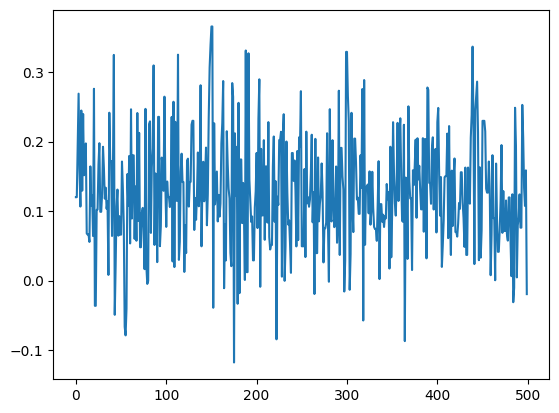

In [311]:
plt.plot(states['e1'])

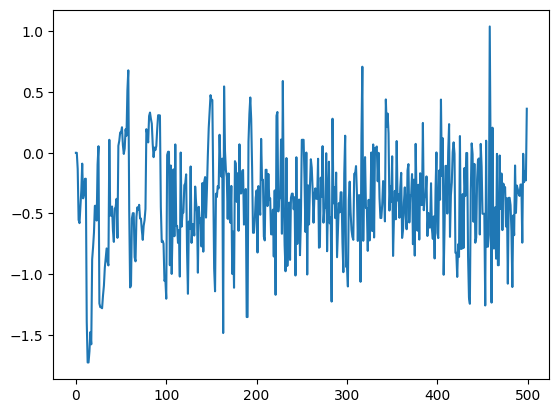

In [312]:
plt.plot(states['dx'])